## Importing Modules

In [1]:
%%capture
!pip install 'transformers == 4.6.0'

In [2]:
import zipfile
import pandas as pd 
import numpy as np
import re
import random 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from tensorflow.keras import layers 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 
from sklearn.metrics import confusion_matrix
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

## Loading Data

In [4]:
zip_path= "/content/drive/MyDrive/Hate Speech Detection Data/train_E6oV3lV.csv.zip"

In [5]:
# Create function to unzip a zipfile into current working directory 
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()
unzip_data(zip_path)


In [6]:
# Read csv file
df = pd.read_csv("/content/train_E6oV3lV.csv")

## Exploring Data 

In [7]:
# Check data
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [8]:
# Drop the id column
df = df.drop('id',axis=1)
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
# Check how many examples each class has
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [ ]:
df_Stat=df[['label','tweet']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,0,29720,92.98542
1,1,2242,7.01458


In [11]:
# Shuffle the data 
df_shuffled = df.sample(frac=1, random_state=42)
df_shuffled.head()

,label,tweet
12227,0,@user âmy mom says my smile is captivatingâ...
14709,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,0,hating the conservative homophobes using this ...
4308,0,awee if this doesn't #scream #friday #acewe...
24055,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [9]:
# Remove symbols from tweets and lower case all characters
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [12]:
df_shuffled['processed_tweets'] = df_shuffled['tweet'].apply(process_tweet)
df_shuffled.head(8)

,label,tweet,processed_tweets
12227,0,@user âmy mom says my smile is captivatingâ...,my mom says my smile is captivating i says hap...
14709,0,"in 3 days i will be meeting my sis-n-law, coun...",in 3 days i will be meeting my sis n law coune...
19319,0,hating the conservative homophobes using this ...,hating the conservative homophobes using this ...
4308,0,awee if this doesn't #scream #friday #acewe...,awee if this doesn t scream friday acewellstuc...
24055,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...,fathersday father s day god tony a smith buy t...
2275,0,grooving fuuuunn nightâ¨â¨â¨ #bangkok #las...,grooving fuuuunn night bangkok lastnight w tha...
22304,0,a very #koala bear,a very koala bear
15297,0,treat people the way you want to be treated. #...,treat people the way you want to be treated be...


In [ ]:
# Visualize some random examples 
random_index = random.randint(0, len(df_shuffled)-10) # create random indexes
for row in df_shuffled[["processed_tweets", "label"]][random_index:random_index+10].itertuples():
  _, tweet, label = row
  print(f"Label: {label}", "(hate speech)" if label > 0 else "(normal speech)")
  print(f"Tweet:\n{tweet}\n")
  print("---\n")

Label: 0 (normal speech)
Tweet:
remember when used to lead on impoant social issues 29 years later they re afraid to even talk abt cannabis whathappened

---

Label: 0 (normal speech)
Tweet:
i think everything in my life right now is a leapoffaith and i m not scared im sta betting on yourself

---

Label: 1 (hate speech)
Tweet:
isn t it time we realized what we ve done hate exploitation read america s history

---

Label: 0 (normal speech)
Tweet:
thanks kidsrehab

---

Label: 0 (normal speech)
Tweet:
is that a jet engine in your pocket or are you just to see me via

---

Label: 0 (normal speech)
Tweet:
cause we lost

---

Label: 0 (normal speech)
Tweet:
ramadan to all mussulmanic twitter friends blesessing month n happy

---

Label: 0 (normal speech)
Tweet:
absolutely disgusted with andover kfc disgusting service the food was cold and horrible and over cooked very

---

Label: 0 (normal speech)
Tweet:
being ignored confused disappointed after so many years i can t see a change sadly i 

Normal speech words


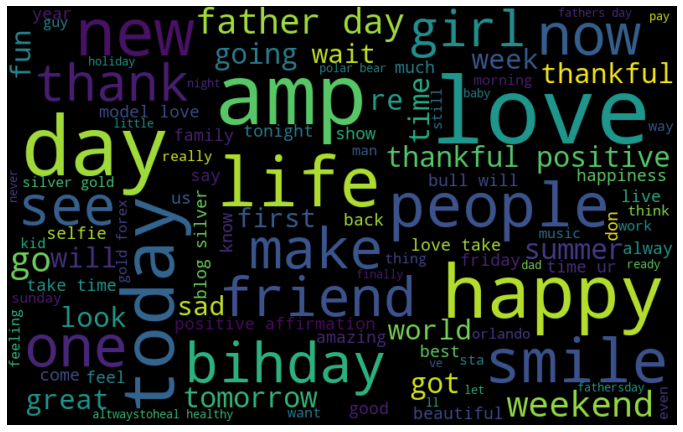

In [ ]:
# Visualize the most frequent words in normal tweets
normal_words = ' '.join([word for word in df_shuffled['processed_tweets'][df_shuffled['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal speech words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off');

Hate speech words


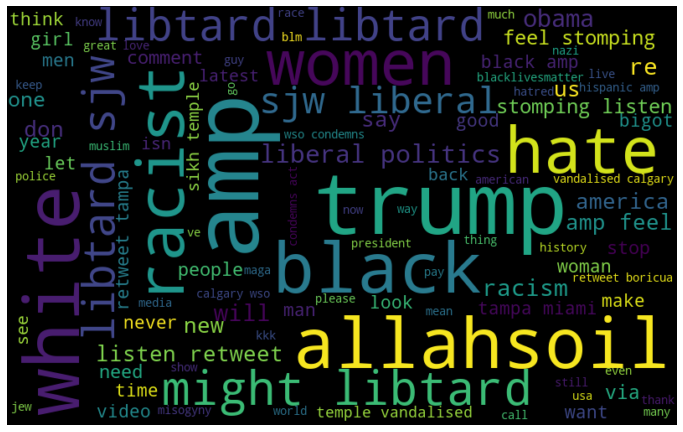

In [ ]:
# Visualize the most frequent words in hate tweets
normal_words = ' '.join([word for word in df_shuffled['processed_tweets'][df_shuffled['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Hate speech words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off');

In [ ]:
# Import stopwords with scikit-learn
stopwords = text.ENGLISH_STOP_WORDS
# Get the top used words from normal tweets excluding stopwords, numbers, and strings with length of one character
normal_words = pd.Series(' '.join(df_shuffled['processed_tweets'][df_shuffled['label'] == 0].apply(lambda x: ' '.join(item for item in str(x).split() if item not in stopwords and not item.isdigit() and len(item)>1))).split()).value_counts()[:30]
normal_words

love         2796
day          2346
happy        1694
amp          1476
just         1288
life         1163
time         1127
today        1080
thankful      952
positive      934
new           931
like          920
bihday        872
good          841
people        792
smile         745
father        650
want          626
don           616
fun           614
healthy       609
weekend       604
work          604
summer        571
family        536
make          532
friday        530
beautiful     523
friends       517
best          513
dtype: int64

In [ ]:
# Get the top used words from hate tweets excluding stopwords, numbers, and strings with length of one character
hate_words = pd.Series(' '.join(df_shuffled['processed_tweets'][df_shuffled['label'] == 1].apply(lambda x: ' '.join(item for item in str(x).split() if item not in stopwords and not item.isdigit() and len(item)>1))).split()).value_counts()[:30]
hate_words

amp          300
trump        213
libtard      149
white        140
like         139
black        134
racist       108
politics      97
people        95
allahsoil     92
liberal       82
just          79
women         78
sjw           74
new           72
obama         72
hate          72
retweet       67
racism        66
don           63
feel          59
listen        57
america       54
stomping      48
right         48
race          47
men           46
miami         46
woman         43
comments      39
dtype: int64

In [ ]:
# Creating a dataframe to represent top 30 normal and hate used words
d1 = pd.DataFrame(normal_words.index,columns = ['Normal_Words'])
d2 = pd.DataFrame(normal_words.values,columns = ['Normal_Count'])
d3 = pd.DataFrame(hate_words.index,columns = ['Hate_Words'])
d4 = pd.DataFrame(hate_words.values,columns = ['Hate_Count'])
word_freq_df = pd.concat([d1,d2,d3,d4], axis = 1)
word_freq_df

,Normal_Words,Normal_Count,Hate_Words,Hate_Count
0,love,2796,amp,300
1,day,2346,trump,213
2,happy,1694,libtard,149
3,amp,1476,white,140
4,just,1288,like,139
5,life,1163,black,134
6,time,1127,racist,108
7,today,1080,politics,97
8,thankful,952,people,95
9,positive,934,allahsoil,92


## Splitting Data into Training and Validation Sets

In [13]:
# Use train_test_split to split training data into training and validation sets 
train_sentences, val_sentences, train_labels, val_labels = train_test_split(list(df_shuffled["processed_tweets"]),
                                                                           list(df_shuffled["label"]),
                                                                           test_size=0.2, # use 10% of training data for validation
                                                                           random_state=42)

In [ ]:
# Find the average number of tokens (words) in the training and validation tweets 
round (sum([len(i.split()) for i in train_sentences])/len(train_sentences)), round (sum([len(i.split()) for i in val_sentences])/len(val_sentences))

(13, 13)

## Running a Series of Modeling Experiments

In [14]:
# Create tokenization and modeling pipeline 


# XGBClassifier
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', xgb.XGBClassifier(use_label =False)),])

model_0 = pipeline_xgb.fit(train_sentences, train_labels)

model_0_score = model_0.score(val_sentences, val_labels)

print(f"Our model_0 (XGBClassifier) achieves an accuracy of:{model_0_score*100:.2f}%")


# MultinomialNB
model_1 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", MultinomialNB()) # model the text
])

model_1.fit(train_sentences, train_labels)
score_1 = model_1.score(val_sentences, val_labels)
print(f"Our model_1 (MultinomialNB) achieves an accuracy of:{score_1*100:.2f}%")


# RandomForestClassifier
model_2 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", RandomForestClassifier()) # model the text
])

model_2.fit(train_sentences, train_labels)
score_2 = model_2.score(val_sentences, val_labels)
print(f"Our model_2 (RandomForestClassifier) achieves an accuracy of:{score_2*100:.2f}%")


# LogisticRegression
model_3 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", LogisticRegression()) # model the text
])

model_3.fit(train_sentences, train_labels)
score_3 = model_3.score(val_sentences, val_labels)
print(f"Our model_3 (LogisticRegression) achieves an accuracy of:{score_3*100:.2f}%")


# SGDClassifier
model_4 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", SGDClassifier()) # model the text
])

model_4.fit(train_sentences, train_labels)
score_4 = model_4.score(val_sentences, val_labels)
print(f"Our model_4 (SGDClassifier) achieves an accuracy of:{score_4*100:.2f}%")

Our model_0 (XGBClassifier) achieves an accuracy of:94.17%
Our model_1 (MultinomialNB) achieves an accuracy of:93.52%
Our model_2 (RandomForestClassifier) achieves an accuracy of:96.15%
Our model_3 (LogisticRegression) achieves an accuracy of:94.81%
Our model_4 (SGDClassifier) achieves an accuracy of:95.12%


In [15]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub 
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE"
                                        )
# Create model using the Sequential API 
model_5 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name = "model_5_USE")

# Compile 
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


Model: "model_5_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [16]:
# Train a classifier on top of USE pretrained embeddings 
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=15,
                              validation_data=(val_sentences, val_labels)
                              )

Epoch 1/15
800/800 [==============================] - 23s 23ms/step - loss: 0.1763 - accuracy: 0.9434 - val_loss: 0.1366 - val_accuracy: 0.9479
Epoch 2/15
800/800 [==============================] - 18s 22ms/step - loss: 0.1225 - accuracy: 0.9564 - val_loss: 0.1289 - val_accuracy: 0.9514
Epoch 3/15
800/800 [==============================] - 18s 22ms/step - loss: 0.1119 - accuracy: 0.9598 - val_loss: 0.1226 - val_accuracy: 0.9550
Epoch 4/15
800/800 [==============================] - 18s 23ms/step - loss: 0.1017 - accuracy: 0.9628 - val_loss: 0.1195 - val_accuracy: 0.9554
Epoch 5/15
800/800 [==============================] - 18s 23ms/step - loss: 0.0928 - accuracy: 0.9671 - val_loss: 0.1164 - val_accuracy: 0.9578
Epoch 6/15
800/800 [==============================] - 19s 23ms/step - loss: 0.0851 - accuracy: 0.9691 - val_loss: 0.1132 - val_accuracy: 0.9576
Epoch 7/15
800/800 [==============================] - 18s 22ms/step - loss: 0.0785 - accuracy: 0.9711 - val_loss: 0.1130 - val_accuracy:

In [17]:
# Make predictions with USE TF Hub Model
model_5_pred_probs = model_5.predict(val_sentences)

In [18]:
# Making predictions on validation data 
y0_predict = model_0.predict(val_sentences)
y1_predict = model_1.predict(val_sentences)
y2_predict = model_2.predict(val_sentences)
y3_predict = model_3.predict(val_sentences)
y4_predict = model_4.predict(val_sentences)
y5_predict = tf.squeeze(tf.round(model_5_pred_probs))

## Creating an Evaluation Function for Model Experiments

In [19]:
# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model 
  """
  # Calculate model accuracy 
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average 
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [20]:
# Get baseline results 
model_0_results = calculate_results(y_true=val_labels,
                                     y_pred= y0_predict)
model_0_results

{'accuracy': 94.16549350852495,
 'f1': 0.9240085458148133,
 'precision': 0.9416924045330635,
 'recall': 0.9416549350852494}

In [21]:
# Get model_1 results 
model_1_results = calculate_results(y_true=val_labels,
                                     y_pred= y1_predict)
model_1_results

{'accuracy': 93.52416705771938,
 'f1': 0.9103555383590493,
 'precision': 0.9394690355064025,
 'recall': 0.9352416705771938}

In [22]:
# Get model_2 results 
model_2_results = calculate_results(y_true=val_labels,
                                     y_pred= y2_predict)
model_2_results

{'accuracy': 96.15204129516658,
 'f1': 0.9559769580284785,
 'precision': 0.9608748344734512,
 'recall': 0.9615204129516659}

In [23]:
# Get model_3 results 
model_3_results = calculate_results(y_true=val_labels,
                                     y_pred= y3_predict)
model_3_results

{'accuracy': 94.80681995933051,
 'f1': 0.9359882323688977,
 'precision': 0.9466040133565261,
 'recall': 0.9480681995933051}

In [24]:
# Get model_4 results 
model_4_results = calculate_results(y_true=val_labels,
                                     y_pred= y4_predict)
model_4_results

{'accuracy': 95.11966213045518,
 'f1': 0.9403984140096124,
 'precision': 0.9512663458826891,
 'recall': 0.9511966213045518}

In [25]:
# Get model_5 results 
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = y5_predict)
model_5_results

{'accuracy': 95.97997810104802,
 'f1': 0.9573663028453151,
 'precision': 0.9567981608471928,
 'recall': 0.9597997810104802}

## Comparing the Performance of the Models

In [26]:
models_results_df = pd.DataFrame(data={'model_0 (XGBClassifier)': model_0_results,
                                       'model_1 (MultinomialNB)': model_1_results,
                                       'model_2 (RandomForestClassifier)' : model_2_results,
                                       'model_3 (LogisticRegression)': model_3_results,
                                       'model_4 (SGDClassifier)' : model_4_results,
                                       'model_5 (TFhub_USE_Encoder)' : model_5_results}).transpose()
models_results_df

,accuracy,precision,recall,f1
model_0 (XGBClassifier),94.165494,0.941692,0.941655,0.924009
model_1 (MultinomialNB),93.524167,0.939469,0.935242,0.910356
model_2 (RandomForestClassifier),96.152041,0.960875,0.961520,0.955977
model_3 (LogisticRegression),94.806820,0.946604,0.948068,0.935988
model_4 (SGDClassifier),95.119662,0.951266,0.951197,0.940398
model_5 (TFhub_USE_Encoder),95.979978,0.956798,0.959800,0.957366


In [27]:
# Reduce the accuracy to the same scale as other metrics 
models_results_df["accuracy"]= models_results_df["accuracy"]/100

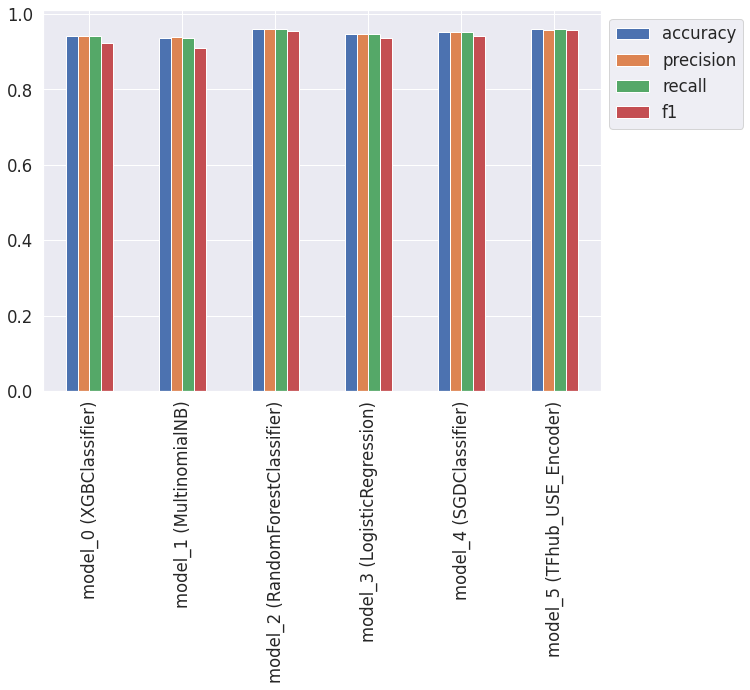

In [43]:
# Plot and compare all of the model results
models_results_df.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

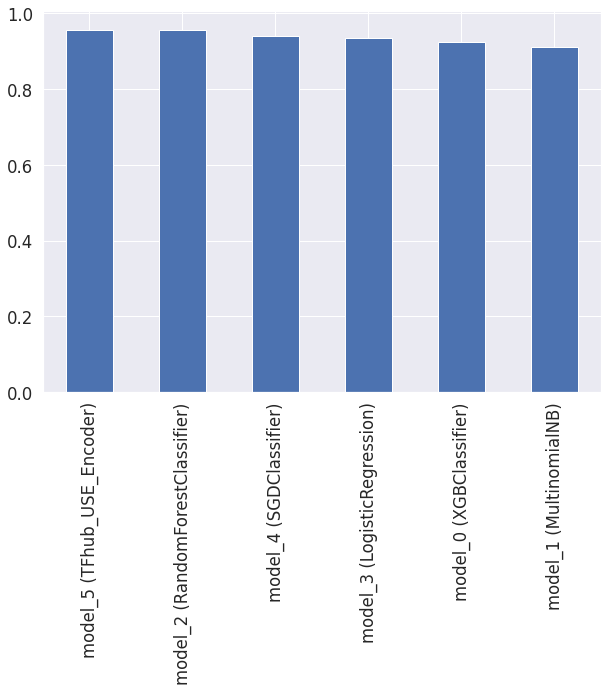

In [44]:
# Sort model results by f1-score
models_results_df.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [30]:
# Confusion matrix
cm_0 = confusion_matrix(val_labels, y0_predict)
cm_0

array([[5922,    6],
       [ 367,   98]])

In [31]:
cm_1 = confusion_matrix(val_labels, y1_predict)
cm_1

array([[5928,    0],
       [ 414,   51]])

In [32]:
cm_2 = confusion_matrix(val_labels, y2_predict)
cm_2

array([[5914,   14],
       [ 232,  233]])

In [33]:
cm_3 = confusion_matrix(val_labels, y3_predict)
cm_3

array([[5915,   13],
       [ 319,  146]])

In [34]:
cm_4 = confusion_matrix(val_labels, y4_predict)
cm_4

array([[5920,    8],
       [ 304,  161]])

In [35]:
cm_5 = confusion_matrix(val_labels, y5_predict)
cm_5

array([[5853,   75],
       [ 182,  283]])

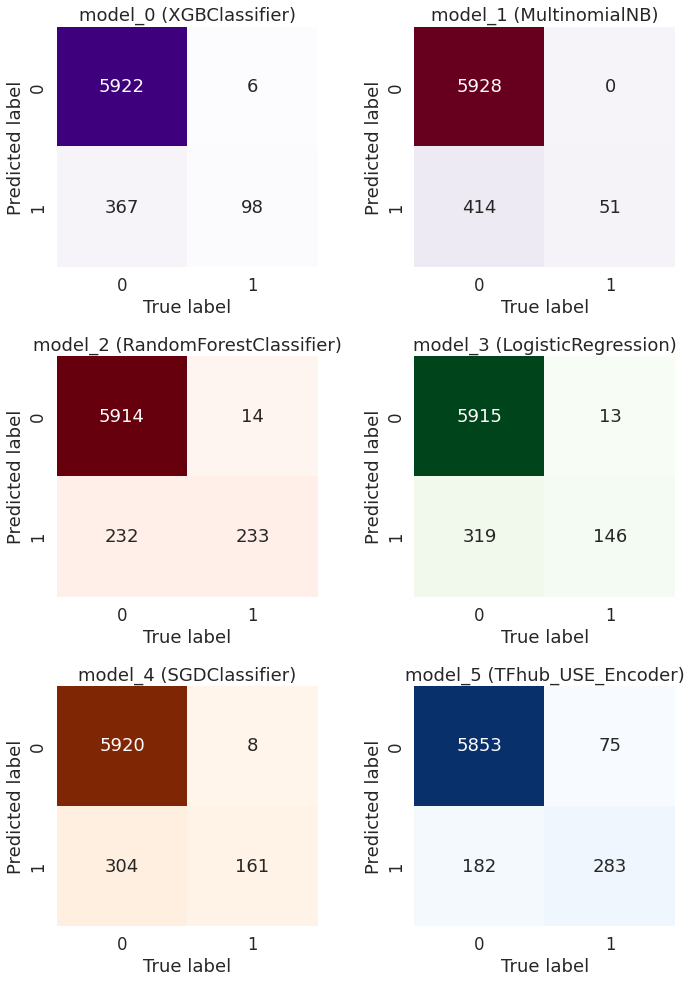

In [36]:
sns.set(font_scale=1.5)
# Plot the confusion matrix for each model
fig, axs = plt.subplots(3, 2,figsize=(10, 14))
sns.heatmap(confusion_matrix(val_labels, y0_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[0, 0],
                  cmap= 'Purples'
                     )
axs[0, 0].set_title('model_0 (XGBClassifier)')
axs[0, 0].set_xlabel("True label")
axs[0, 0].set_ylabel("Predicted label")

sns.heatmap(confusion_matrix(val_labels, y1_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[0, 1],
                  cmap='PuRd'
                     )
axs[0, 1].set_title('model_1 (MultinomialNB)')
axs[0, 1].set_xlabel("True label")
axs[0, 1].set_ylabel("Predicted label")


sns.heatmap(confusion_matrix(val_labels, y2_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[1, 0],
                  cmap='Reds'
                     )
axs[1, 0].set_title('model_2 (RandomForestClassifier)')
axs[1, 0].set_xlabel("True label")
axs[1, 0].set_ylabel("Predicted label")


sns.heatmap(confusion_matrix(val_labels, y3_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[1, 1],
                  cmap='Greens'
                     )
axs[1, 1].set_title('model_3 (LogisticRegression)')
axs[1, 1].set_xlabel("True label")
axs[1, 1].set_ylabel("Predicted label")



sns.heatmap(confusion_matrix(val_labels, y4_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[2, 0],
                  cmap='Oranges'
                     )
axs[2, 0].set_title('model_4 (SGDClassifier)')
axs[2, 0].set_xlabel("True label")
axs[2, 0].set_ylabel("Predicted label")


sns.heatmap(confusion_matrix(val_labels, y5_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[2, 1],
                  cmap='Blues'
                     )
axs[2, 1].set_title('model_5 (TFhub_USE_Encoder)')
axs[2, 1].set_xlabel("True label")
axs[2, 1].set_ylabel("Predicted label")
plt.tight_layout(); 

In [ ]:
# Save the best model
model_5.save('tfhub_use_encoder.h5')

## Finding the Most Wrong Examples

In [37]:
# Create DataFrame with validation sentences and best performing model prediction labels + probabilities  
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": y5_predict,
                       "pred_prob": tf.squeeze(model_5_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,turn it in abc for 20 20 sobering,0,0.0,0.020925
1,oh no thursdays is noodle day what have you do...,0,0.0,0.000044
2,here we go let s do this people icrs2016,0,0.0,0.046971
3,water in me and around me sam sierra michael b...,0,0.0,0.000387
4,awesome beginner gopro mounts super to use,0,0.0,0.000004


In [38]:
# Find the wrong predictions and sort by prediction probabilities 
most_wrong = val_df[val_df["target"] !=val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong

,text,target,pred,pred_prob
4272,lgbtqhatestrumppay but luvs homophobic misogyn...,0,1.0,0.998476
6184,south sudan unrest exacerbated by conflict amo...,0,1.0,0.996114
558,what lies these dt suppoers are spreading look...,0,1.0,0.995952
6054,i award thee most cucked tweet in history prep...,0,1.0,0.993068
1344,ali spoke the truth about white folks period f...,0,1.0,0.983793
...,...,...,...,...
5222,2 99 2016release ebook book the summer that me...,1,0.0,0.000210
3620,now ask yourself if you really want to follow ...,1,0.0,0.000082
5568,good afternoon sweety send me letter,1,0.0,0.000046
1063,funny can t get rid of 7 1stammendment so many...,1,0.0,0.000031


In [39]:
# False positives
most_wrong.head()

,text,target,pred,pred_prob
4272,lgbtqhatestrumppay but luvs homophobic misogyn...,0,1.0,0.998476
6184,south sudan unrest exacerbated by conflict amo...,0,1.0,0.996114
558,what lies these dt suppoers are spreading look...,0,1.0,0.995952
6054,i award thee most cucked tweet in history prep...,0,1.0,0.993068
1344,ali spoke the truth about white folks period f...,0,1.0,0.983793


In [40]:
# False negative
most_wrong.tail()

,text,target,pred,pred_prob
5222,2 99 2016release ebook book the summer that me...,1,0.0,0.000210
3620,now ask yourself if you really want to follow ...,1,0.0,0.000082
5568,good afternoon sweety send me letter,1,0.0,0.000046
1063,funny can t get rid of 7 1stammendment so many...,1,0.0,0.000031
1153,i m blessedt iconic lovebeingalegend,1,0.0,0.000002


In [41]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row 
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0, Pred: 1.0, Prob: 0.9984763264656067
Text:
lgbtqhatestrumppay but luvs homophobic misogynist antisemitic death cult masquerading as a religion

---

Target: 0, Pred: 1.0, Prob: 0.9961138963699341
Text:
south sudan unrest exacerbated by conflict among cattle herders global development the guardian oil

---

Target: 0, Pred: 1.0, Prob: 0.995951771736145
Text:
what lies these dt suppoers are spreading looks like propaganda from the 1930s

---

Target: 0, Pred: 1.0, Prob: 0.9930675029754639
Text:
i award thee most cucked tweet in history prep the bull you insufferable faggot sbc16

---

Target: 0, Pred: 1.0, Prob: 0.983792781829834
Text:
ali spoke the truth about white folks period facts idiot moron theverycoreofamerica

---

Target: 0, Pred: 1.0, Prob: 0.9787778854370117
Text:
reason 638 on why i don t suppo modern day feminism it s no longer about women s rights in america

---

Target: 0, Pred: 1.0, Prob: 0.9772565364837646
Text:
epic video blm zombie vs trump kids youcanalway

In [42]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row 
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1, Pred: 0.0, Prob: 0.0022815479896962643
Text:
great aicle of truth about trc needs comments back up why it s needed indignenous via

---

Target: 1, Pred: 0.0, Prob: 0.001935787033289671
Text:
sunbury pennsylvania fliers posted outside mosque muslim usa

---

Target: 1, Pred: 0.0, Prob: 0.0017301107291132212
Text:
this newyearseve may our resolutions b 2 end problems like amp domesticviolence by turning 2 god of love

---

Target: 1, Pred: 0.0, Prob: 0.0014063128037378192
Text:
ouuh fuck it bustymilf

---

Target: 1, Pred: 0.0, Prob: 0.0002943870786111802
Text:
note i was just able to pop this zit on my neck that s been there for days i ve beensqueezing it for days

---

Target: 1, Pred: 0.0, Prob: 0.00020982566638849676
Text:
2 99 2016release ebook book the summer that melted everything a novel by tiffany mcdaniel via

---

Target: 1, Pred: 0.0, Prob: 8.237099973484874e-05
Text:
now ask yourself if you really want to follow i m done

---

Target: 1, Pred: 0.0, Prob: 4.607046

## Another Option: Using DistilBertTokenizerFast

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_sentences, truncation=True, padding=True)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
train_dataset

<TensorSliceDataset shapes: ({input_ids: (46,), attention_mask: (46,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [ ]:
len(val_labels)

6393

In [ ]:
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
    model_6 = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model_6,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
score_6 = trainer.evaluate(val_dataset)
score_6

{'eval_loss': 0.1283090591430664}

In [ ]:
trainer.predict(val_dataset)

PredictionOutput(predictions=array([[ 4.082168 , -3.6003118],
       [ 4.376106 , -3.9224284],
       [ 4.383813 , -3.8916414],
       ...,
       [ 4.5240517, -4.052749 ],
       [ 4.6098285, -4.105955 ],
       [ 4.4747515, -4.06271  ]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0], dtype=int32), metrics={'eval_loss': 0.1273474597930908})

In [ ]:
y6_predict_proba=trainer.predict(val_dataset)[0] 

y6_predict=np.argmax(y6_predict_proba,axis=-1)

In [ ]:
# Get model_6 results 
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred= y6_predict)
model_6_results

{'accuracy': 96.5274519005162,
 'f1': 0.9644764593802877,
 'precision': 0.9639728208229673,
 'recall': 0.9652745190051619}

In [ ]:
model_6_results_df=pd.DataFrame(data={'model_6 (DistilBertTokenizerFast)': model_6_results}).transpose()
model_6_results_df

,accuracy,f1,precision,recall
model_6 (DistilBertTokenizerFast),96.527452,0.964476,0.963973,0.965275


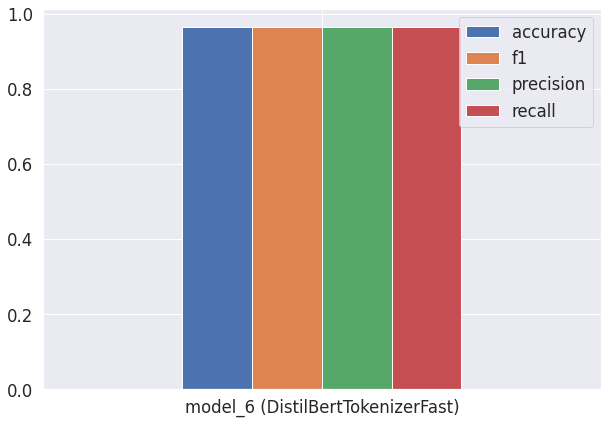

In [ ]:
# Reduce the accuracy to the same scale as other metrics 
model_6_results_df["accuracy"]= model_6_results_df["accuracy"]/100
model_6_results_df.plot(kind="bar", figsize=(10, 7))
plt.xticks(rotation='horizontal');

In [ ]:
np.unique(val_labels,return_counts=True)

(array([0, 1]), array([5928,  465]))

In [ ]:
cm_6 = confusion_matrix(val_labels, y6_predict)
cm_6

array([[5839,   89],
       [ 133,  332]])

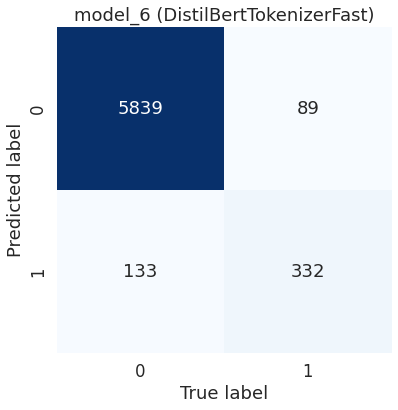

In [ ]:
# Plot the confusion matrix for model_6
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(val_labels, y6_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  cmap='Blues'
                     )
plt.title('model_6 (DistilBertTokenizerFast)')
plt.xlabel('True label')
plt.ylabel('Predicted label'); 

In [ ]:
trainer.save_model("distilbert_model")